In [1]:
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import shutil
from tqdm import tqdm
import matplotlib.ticker as mticker

In [45]:
from model import Discriminator, Generator
from model import train_discriminator, train_generator
from dataset import CakeDataset
from helper_functions import display_loss_curves, display_sample_images
from helper_functions import load_checkpoint_and_initialize_objects

# Dataset

In [3]:
data_path = "crawled_cakes"
dataset = CakeDataset(data_path, augmentation=True)

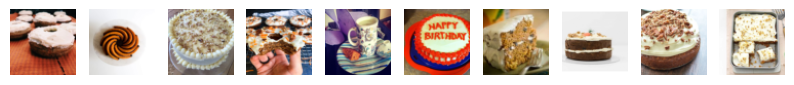

In [4]:
dataset.show_samples(num_samples=10)

# Training

In [5]:
log_dir = "training_logs"
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
os.makedirs(log_dir)

log_file_path = os.path.join(log_dir, "training_logs.txt")
with open(log_file_path, "w") as log_file:
    log_file.write("Training Logs\n\n")

In [6]:
device = torch.device("mps")
batch_size = 32
num_epochs = 3000
checkpoint_frequency = 50

discriminator_lr = 0.00001
discriminator_weight_decay = 0.0001
generator_lr = 0.00001
generator_weight_decay = 0.0001

leaky_relu_neg_slope = 0.2

discriminator_feature_maps = [64, 128, 128]
dropout_rate = 0.2

generator_feature_maps = [128, 256, 512]
noise_dim = 128

In [7]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
discriminator = Discriminator(
    feature_maps=discriminator_feature_maps,
    dropout_rate=dropout_rate,
    leaky_relu_neg_slope=leaky_relu_neg_slope,
).to(device)

generator = Generator(
    feature_maps=generator_feature_maps,
    noise_dim=noise_dim,
    leaky_relu_neg_slope=leaky_relu_neg_slope,
).to(device)

In [9]:
d_optimizer = optim.Adam(
    discriminator.parameters(),
    lr=discriminator_lr,
    weight_decay=discriminator_weight_decay,
)

g_optimizer = optim.Adam(
    generator.parameters(),
    lr=generator_lr,
    weight_decay=generator_weight_decay,
)

In [10]:
fixed_noise = torch.randn(batch_size, noise_dim).to(device)

In [11]:
mean_d_losses = []
mean_g_losses = []

In [1]:
for epoch in range(num_epochs):
    d_losses, g_losses = [], []
    
    for real_images in tqdm(dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False):
        real_images = real_images.to(device)
        
        # Generate fake images
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_images = generator(noise)
        
        # Train Discriminator
        d_loss = train_discriminator(discriminator, real_images, fake_images.detach(), d_optimizer, device)
        d_losses.append(d_loss)
        
        # Train Generator
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_images = generator(noise)
        g_loss = train_generator(generator, discriminator, fake_images, g_optimizer, device)
        g_losses.append(g_loss)
    
    mean_d_loss = np.mean(d_losses)
    mean_d_losses.append(mean_d_loss)
    mean_g_loss = np.mean(g_losses)
    mean_g_losses.append(mean_g_loss)

    # Log epoch losses
    epoch_log = f"Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {mean_d_loss:.4f}, Generator Loss: {mean_g_loss:.4f}"
    print(epoch_log)
    
    with open(log_file_path, "a") as log_file:
        log_file.write(epoch_log + "\n")
    
    # Save model and generate samples every 'n' epochs
    if (epoch + 1) % checkpoint_frequency == 0:
        # Save model checkpoint
        torch.save({
            "epoch": epoch + 1,
            "generator": generator.state_dict(),
            "discriminator": discriminator.state_dict(),
            "d_optimizer": d_optimizer.state_dict(),
            "g_optimizer": g_optimizer.state_dict(),
            "fixed_noise": fixed_noise,
            "d_losses": d_losses,
            "g_losses": g_losses,
            "mean_d_losses": mean_d_losses,
            "mean_g_losses": mean_g_losses
        }, os.path.join(log_dir, f"gan_checkpoint_epoch_{epoch+1}.pth"))
        
        # Generate and save sample images
        with torch.no_grad():
            samples = generator(fixed_noise).permute(0, 2, 3, 1)  # [B, H, W, C]
            samples = (samples + 1) / 2  # Scale from [-1, 1] to [0, 1]
            for i in range(batch_size):
                plt.subplot(4, batch_size // 4, i + 1)
                plt.imshow(samples[i].cpu().numpy())
                plt.axis("off")
            plt.savefig(os.path.join(log_dir, f"sample_images_epoch_{epoch+1}.png"))
            plt.close()
        
        # Plot and save loss curves
        plt.figure(figsize=(8, 6))
        plt.plot(mean_d_losses, label='Discriminator Loss', color='blue')
        plt.plot(mean_g_losses, label='Generator Loss', color='orange')
        plt.xlabel('Epochs', fontsize=14)
        plt.ylabel('Loss', fontsize=14)
        plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.savefig(os.path.join(log_dir, f"loss_curves_epoch_{epoch+1}.png"))
        plt.close()

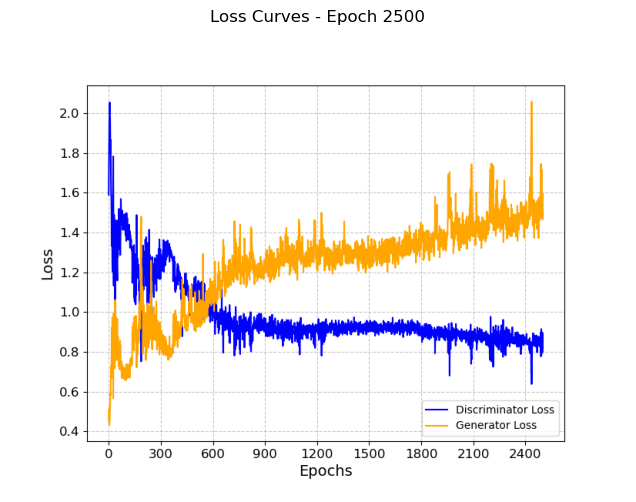

In [20]:
display_loss_curves(log_dir, 2500)

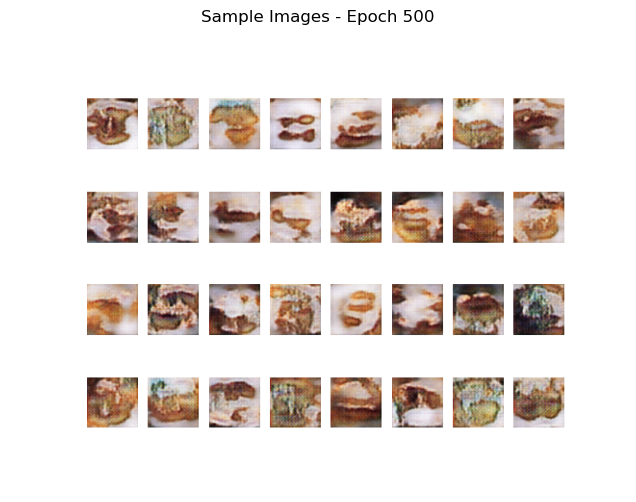

In [21]:
display_sample_images(log_dir, 500)

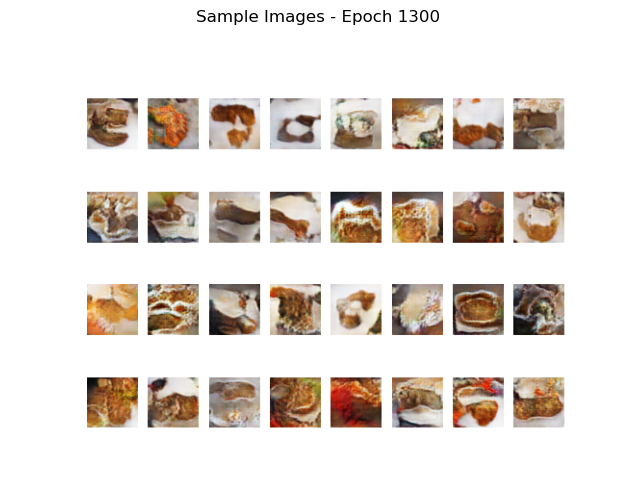

In [22]:
display_sample_images(log_dir, 1300)

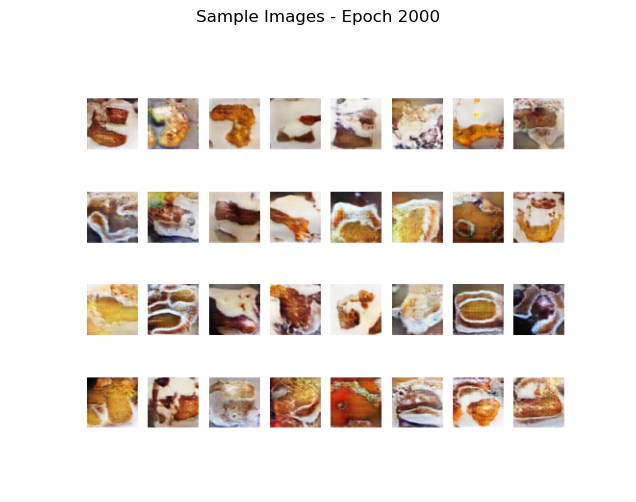

In [23]:
display_sample_images(log_dir, 2000)

# Continue Training from Epoch 50

In [27]:
resume_log_dir = "training_resumed_logs"

if os.path.exists(resume_log_dir):
    shutil.rmtree(resume_log_dir)
os.makedirs(resume_log_dir)

In [28]:
resume_log_file_path = os.path.join(resume_log_dir, "training_logs.txt")
with open(resume_log_file_path, "w") as log_file:
    log_file.write("Resumed Training Logs\n\n")

- Decreased the discriminator's learning rate and increased the weight decay

In [46]:
discriminator_config = {
    "feature_maps": discriminator_feature_maps,
    "dropout_rate": dropout_rate,
    "leaky_relu_neg_slope": leaky_relu_neg_slope
}
generator_config = {
    "feature_maps": generator_feature_maps,
    "noise_dim": noise_dim,
    "leaky_relu_neg_slope": leaky_relu_neg_slope
}
d_optimizer_config = {
    "lr": 0.000005,
    "weight_decay": 0.0002
}
g_optimizer_config = {
    "lr": 0.00001,
    "weight_decay": 0.0001
}


In [49]:
checkpoint = load_checkpoint_and_initialize_objects(log_dir, 500, discriminator_config, generator_config, d_optimizer_config, g_optimizer_config, device)

In [50]:
discriminator = checkpoint["discriminator"]
generator = checkpoint["generator"]
d_optimizer = checkpoint["d_optimizer"]
g_optimizer = checkpoint["g_optimizer"]

In [51]:
fixed_noise = checkpoint["fixed_noise"]
mean_d_losses = checkpoint["mean_d_losses"]
mean_g_losses = checkpoint["mean_g_losses"]
start_epoch = checkpoint["epoch"]

In [52]:
num_epochs = 2000

In [2]:
# Resume training from checkpoint epoch
for epoch in range(start_epoch, num_epochs):
    d_losses, g_losses = [], []
    
    for real_images in tqdm(dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False):
        real_images = real_images.to(device)
        
        # Generate fake images
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_images = generator(noise)
        
        # Train Discriminator with 10% probability of labels shuffling (real=fake and fake=real)
        d_loss = train_discriminator(discriminator, real_images, fake_images.detach(), d_optimizer, device, shuffle_labels=True)
        d_losses.append(d_loss)
        
        # Train Generator
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_images = generator(noise)
        g_loss = train_generator(generator, discriminator, fake_images, g_optimizer, device)
        g_losses.append(g_loss)
    
    mean_d_loss = np.mean(d_losses)
    mean_d_losses.append(mean_d_loss)
    mean_g_loss = np.mean(g_losses)
    mean_g_losses.append(mean_g_loss)

    # Log epoch losses
    epoch_log = f"Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {mean_d_loss:.4f}, Generator Loss: {mean_g_loss:.4f}"
    print(epoch_log)
    
    with open(resume_log_file_path, "a") as log_file:
        log_file.write(epoch_log + "\n")
    
    # Save model and generate samples every 'n' epochs
    if (epoch + 1) % checkpoint_frequency == 0:
        # Save model checkpoint
        torch.save({
            "epoch": epoch + 1,
            "generator": generator.state_dict(),
            "discriminator": discriminator.state_dict(),
            "d_optimizer": d_optimizer.state_dict(),
            "g_optimizer": g_optimizer.state_dict(),
            "fixed_noise": fixed_noise,
            "d_losses": d_losses,
            "g_losses": g_losses,
            "mean_d_losses": mean_d_losses,
            "mean_g_losses": mean_g_losses
        }, os.path.join(resume_log_dir, f"gan_checkpoint_epoch_{epoch+1}.pth"))
        
        # Generate and save sample images
        with torch.no_grad():
            samples = generator(fixed_noise).permute(0, 2, 3, 1)  # [B, H, W, C]
            samples = (samples + 1) / 2  # Scale from [-1, 1] to [0, 1]
            for i in range(batch_size):
                plt.subplot(4, batch_size // 4, i + 1)
                plt.imshow(samples[i].cpu().numpy())
                plt.axis("off")
            plt.savefig(os.path.join(resume_log_dir, f"sample_images_epoch_{epoch+1}.png"))
            plt.close()
        
        # Plot and save loss curves
        plt.figure(figsize=(8, 6))
        plt.plot(mean_d_losses, label='Discriminator Loss', color='blue')
        plt.plot(mean_g_losses, label='Generator Loss', color='orange')
        plt.xlabel('Epochs', fontsize=14)
        plt.ylabel('Loss', fontsize=14)
        plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.savefig(os.path.join(resume_log_dir, f"loss_curves_epoch_{epoch+1}.png"))
        plt.close()

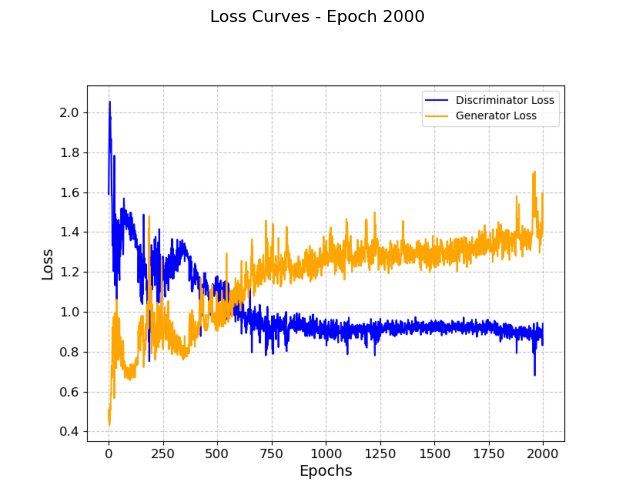

In [56]:
display_loss_curves(log_dir, 2000)

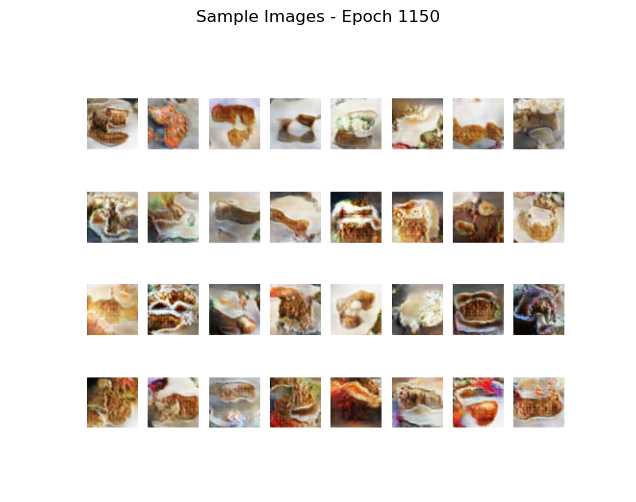

In [57]:
display_sample_images(log_dir, 1150)

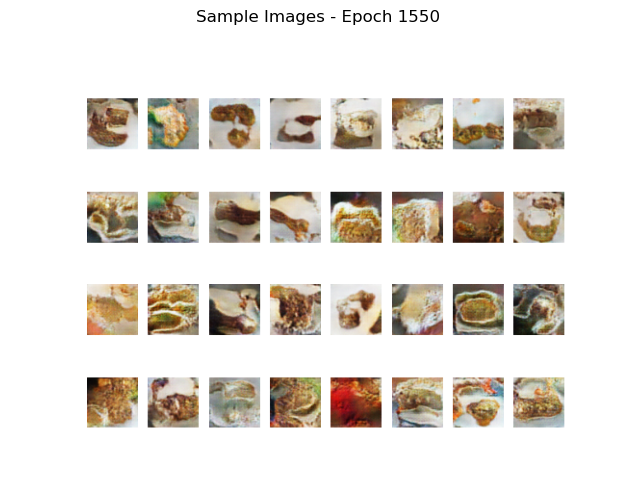

In [58]:
display_sample_images(log_dir, 1550)

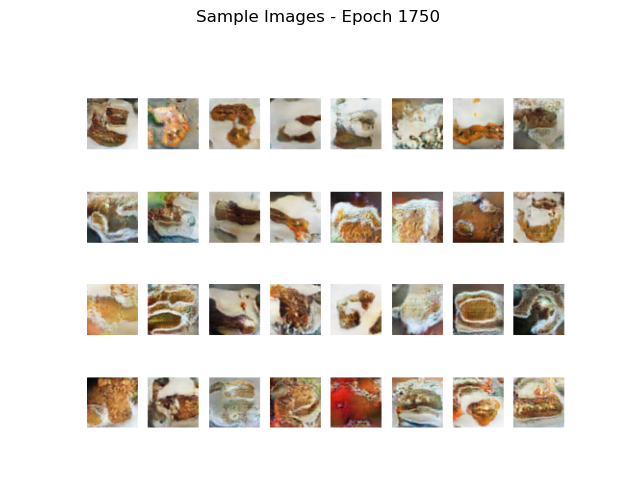

In [59]:
display_sample_images(log_dir, 1750)

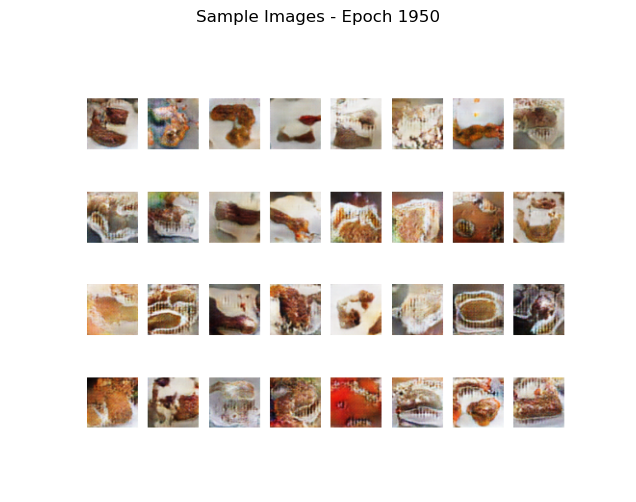

In [60]:
display_sample_images(log_dir, 1950)